<a href="https://colab.research.google.com/github/ovimasbul83/ovimasbul83/blob/main/dcganmywork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification

100% 346M/346M [00:02<00:00, 210MB/s]
100% 346M/346M [00:02<00:00, 179MB/s]


In [5]:
!unzip /content/intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [86]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
import torchvision
def show_tensor_images(image_tensor, num_images=25):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = ((image_tensor + 1.0) / 2.0)
    image_unflat = image_tensor.detach()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute().squeeze())
    plt.show()

In [70]:
class Generator(nn.Module):
  def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

  def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
                
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
                nn.Tanh()
                
                #### END CODE HERE ####
            )
  def unsqueeze_noise(self, noise):
    return noise.view(len(noise), self.z_dim, 1, 1)
  def forward(self, noise):
    x = self.unsqueeze_noise(noise)
    return self.gen(x)
def get_noise(n_samples, z_dim, device='cpu'):
  return torch.randn(n_samples, z_dim, device=device)


In [71]:
class Discriminator(nn.Module):
    
    def __init__(self, im_chan=3, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 3, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                
                nn.Conv2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
          
                
            )
        else: 
            return nn.Sequential(
            
                nn.Conv2d(input_channels,output_channels,kernel_size=kernel_size,stride=stride)
                
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [72]:
criterion=nn.BCEWithLogitsLoss()
z_dim=64
displaystep=500
batch_size=128
lr=0.0002
beta_1=0.5
beta_2=0.999
device='cuda'
train_dir='/content/seg_train/seg_train'
test_dir='/content/seg_test/seg_test'
from torchvision.transforms.transforms import RandomCrop
data_transforms=transforms.Compose([transforms.Resize((64,64)),
                                    transforms.RandomCrop(size=(64,64)),
                                    transforms.ColorJitter(hue=.3,brightness=.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205)),
                                    ])
test_transforms = transforms.Compose([transforms.Resize((64, 64)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))])

'''transform=transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize((0.5,),(0.5,)),
                             ])
dataloader=DataLoader(MNIST('.',download=True,transform=transform),
                      batch_size=batch_size,
                      shuffle=True)'''
data_train=datasets.ImageFolder(root=train_dir,transform=data_transforms)
data_test = datasets.ImageFolder(root=test_dir,transform=test_transforms )
trainloader=DataLoader(data_train,batch_size=23,shuffle=True)
testloader=DataLoader(data_test,batch_size=23,shuffle=True)

print(len(data_train), len(data_test))
data_train


14034 3000


Dataset ImageFolder
    Number of datapoints: 14034
    Root location: /content/seg_train/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomCrop(size=(64, 64), padding=None)
               ColorJitter(brightness=[0.5, 1.5], contrast=None, saturation=None, hue=[-0.3, 0.3])
               ToTensor()
               Normalize(mean=(0.425, 0.415, 0.405), std=(0.205, 0.205, 0.205))
           )

In [73]:
for img,labels in tqdm(trainloader):
  labels

  0%|          | 0/611 [00:00<?, ?it/s]

In [74]:
img.shape

torch.Size([4, 3, 64, 64])

In [75]:
gen=Generator(z_dim).to(device)
gen_opt=torch.optim.Adam(gen.parameters(),lr=lr,betas=(beta_1,beta_2))

In [76]:
disc=Discriminator().to(device)
disc_opt=torch.optim.Adam(disc.parameters(),lr=lr,betas=(beta_1,beta_2))

In [77]:
from torch.nn.modules.conv import ConvTranspose2d
def weights_init(m):
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight,0.0,0.02)
  if isinstance(m,nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight,0.0,0.02)
    torch.nn.init.constant_(m.bias,0.0)
gen=gen.apply(weights_init)
disc=disc.apply(weights_init)

  0%|          | 0/611 [00:00<?, ?it/s]

Step 500: Generator loss: 0.7133907682895657, discriminator loss: 0.6603868811130521


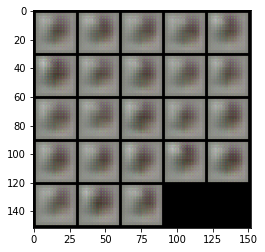

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


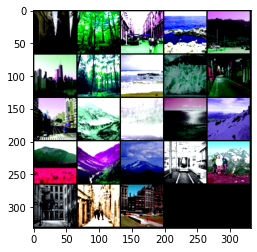

  0%|          | 0/611 [00:00<?, ?it/s]

Step 1000: Generator loss: 0.7560293918251985, discriminator loss: 0.6747096946239468


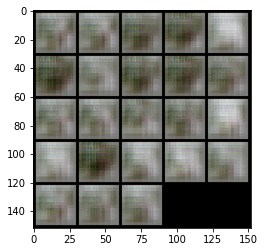

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


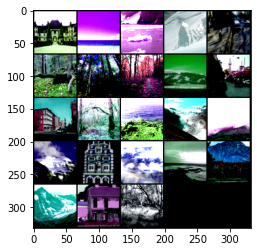

  0%|          | 0/611 [00:00<?, ?it/s]

Step 1500: Generator loss: 0.7221239305734636, discriminator loss: 0.6824900192022322


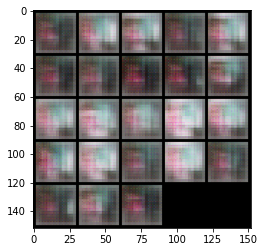

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


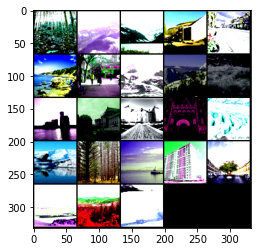

  0%|          | 0/611 [00:00<?, ?it/s]

Step 2000: Generator loss: 0.7212270579338073, discriminator loss: 0.6874241043329236


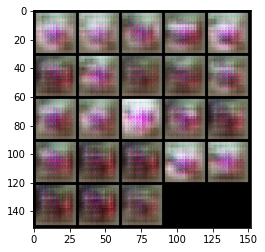

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


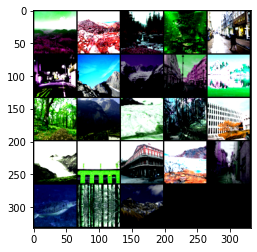

  0%|          | 0/611 [00:00<?, ?it/s]

Step 2500: Generator loss: 0.7229167129993438, discriminator loss: 0.6843760586977006


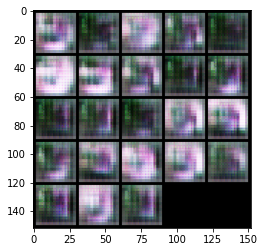

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


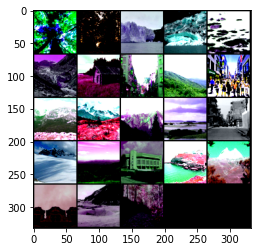

Step 3000: Generator loss: 0.7155522254705418, discriminator loss: 0.6883352018594743


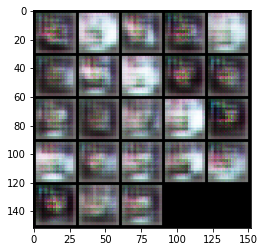

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


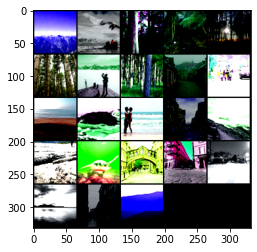

  0%|          | 0/611 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.708186236381531, discriminator loss: 0.6907692346572879


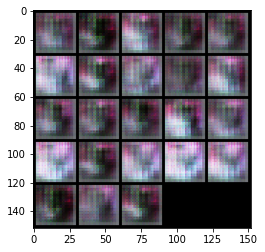

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


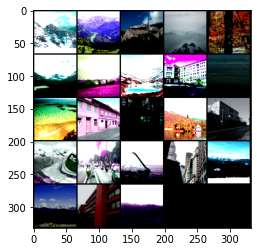

  0%|          | 0/611 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.7165297495126731, discriminator loss: 0.6895965058803566


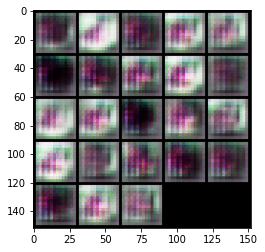

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


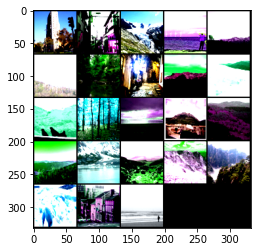

  0%|          | 0/611 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.7222333489656451, discriminator loss: 0.6856879270076752


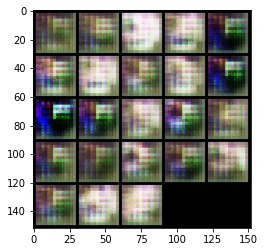

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


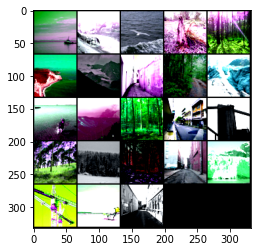

  0%|          | 0/611 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.723774434089662, discriminator loss: 0.6881297199726103


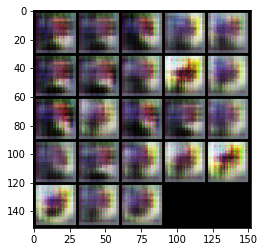

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


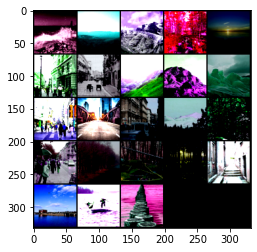

  0%|          | 0/611 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.7213607494831082, discriminator loss: 0.6897252492904666


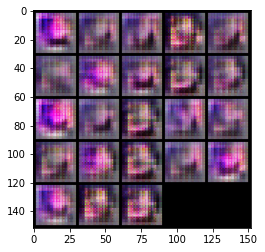

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


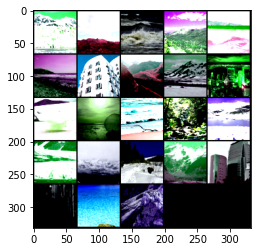

Step 6000: Generator loss: 0.7074260740280155, discriminator loss: 0.6956526784896854


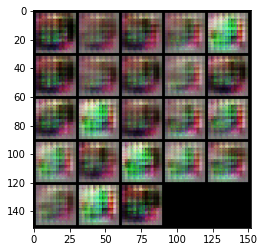

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


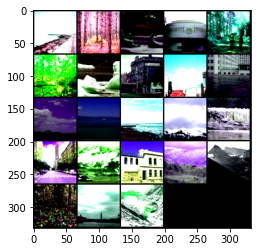

In [78]:
n_epochs = 10
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):

    for real, _ in tqdm(trainloader):
        cur_batch_size = len(real)
        real = real.to(device)

        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        mean_discriminator_loss += disc_loss.item() / displaystep
        disc_loss.backward()
        disc_opt.step()
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
        mean_generator_loss += gen_loss.item() / displaystep
        if cur_step % displaystep == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1




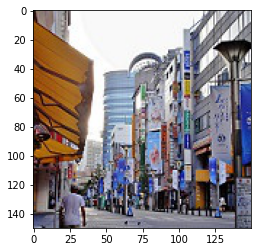

In [79]:
img=plt.imread('/content/seg_train/seg_train/street/1000.jpg')
plt.imshow(img)

  0%|          | 0/611 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


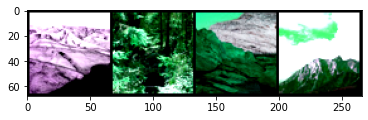

In [84]:
for real, _ in tqdm(trainloader):
  x=len(real)
show_tensor_images(real)
        

In [90]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


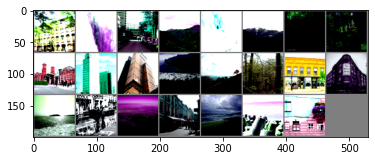

In [91]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

